In [ ]:
!pip install ultralytics
!pip install scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 37.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 84.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 59.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 64.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split
from ultralytics import YOLO
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
def split_train_val(base_dir, val_size=0.2):
    classes = [folder for folder in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, folder))]

    train_images = []
    val_images = []

    for class_name in classes:
        class_folder = os.path.join(base_dir, class_name)
        images = [os.path.join(class_folder, f) for f in os.listdir(class_folder) if f.endswith('.jpeg')]

        if len(images) == 0:
            continue

        train, val = train_test_split(images, test_size=val_size, random_state=42)
        train_images.extend([(img, class_name) for img in train])
        val_images.extend([(img, class_name) for img in val])

    if len(train_images) == 0:
        raise ValueError("No images were selected for the training set.")
    if len(val_images) == 0:
        raise ValueError("No images were selected for the validation set.")

    train_dir = "/content/split/train"
    val_dir = "/content/split/val"

    for class_name in classes:
        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)
    for img, class_name in train_images:
        shutil.move(img, os.path.join(train_dir, class_name, os.path.basename(img)))
    for img, class_name in val_images:
        shutil.move(img, os.path.join(val_dir, class_name, os.path.basename(img)))

    return train_dir, val_dir


def train_yolo(epochs=100, batch_size=32):
    model = YOLO("yolov8n-cls.pt")
    model.train(data="/content/split", epochs=epochs, batch=batch_size, imgsz = 300, device="0")
    return model

def test_and_generate_matrix(model, test_dir):
    results = model.predict(os.path.join(test_dir, "ok_front")) + model.predict(os.path.join(test_dir, "def_front"))

    y_true = []
    y_pred = []
    inference_time = 0
    i = 0
    for result in results:

      true_label = result.path.split('/')[-2]
      y_true.append(true_label)

      predicted_class = result.probs.top1
      predicted_label = model.names[predicted_class]
      y_pred.append(predicted_label)
      if true_label != predicted_label:
        result.show()
        result.save(f"missclassification_{i}.png")

      inference_time += result.speed['inference']
      i += 1

    inference_time = np.mean(inference_time)
    print(f"Inference time: {inference_time:.2f} ms")

    cm = confusion_matrix(y_true, y_pred, labels=['def_front', 'ok_front'])
    cm_display = ConfusionMatrixDisplay(cm, display_labels=model.names.values())

    cm_display.plot(cmap=plt.cm.Blues)
    plt.show()

    report = classification_report(y_true, y_pred, target_names=model.names.values())
    print(report)

In [ ]:
!rm -rf *
!curl -u leprieto:${SECRET} -o dataset.zip "https://cloud.leonprieto.com/remote.php/dav/files/leprieto/University/UEM/TFM/resources/00_clean_filtered_dataset/dataset.zip"
!unzip -q dataset.zip
!rm dataset.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  198M  100  198M    0     0  8080k      0  0:00:25  0:00:25 --:--:-- 9781k


100%|██████████| 5.31M/5.31M [00:00<00:00, 321MB/s]


Ultralytics 8.3.146 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/split, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=300, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n-cls.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True, profi

100%|██████████| 5.35M/5.35M [00:00<00:00, 209MB/s]


AMP: checks passed ✅
WARNING ⚠️ imgsz=[300] must be multiple of max stride 32, updating to [320]
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 521.1±193.0 MB/s, size: 9.7 KB)


train: Scanning /content/split/train... 5254 images, 0 corrupt: 100%|██████████| 5254/5254 [00:00<00:00, 5543.02it/s]

train: New cache created: /content/split/train.cache


val: Fast image access ✅ (ping: 0.3±0.6 ms, read: 242.2±90.1 MB/s, size: 9.2 KB)


val: Scanning /content/split/val... 1315 images, 0 corrupt: 100%|██████████| 1315/1315 [00:00<00:00, 2985.52it/s]

val: New cache created: /content/split/val.cache


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 26 weight(decay=0.0), 27 weight(decay=0.0005), 27 bias(decay=0.0)
Image sizes 320 train, 320 val
Using 2 dataloader workers
Logging results to runs/classify/train
Starting training for 100 epochs...

      Epoch    GPU_mem       loss  Instances       Size


      1/100     0.922G     0.6641         32        320:   4%|▎         | 6/165 [00:03<00:54,  2.91it/s]

      1/100     0.922G     0.6739         32        320:   6%|▌         | 10/165 [00:04<00:47,  3.24it/s]
100%|██████████| 755k/755k [00:00<00:00, 120MB/s]
      1/100     0.936G      0.329          6        320: 100%|██████████| 165/165 [00:55<00:00,  2.99it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 21/21 [00:06<00:00,  3.23it/s]

                   all      0.992          1



      Epoch    GPU_mem       loss  Instances       Size


      2/100      1.14G     0.1079          6        320: 100%|██████████| 165/165 [00:52<00:00,  3.15it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 21/21 [00:05<00:00,  3.64it/s]

                   all      0.785          1



      Epoch    GPU_mem       loss  Instances       Size


      3/100      1.15G     0.1169          6        320: 100%|██████████| 165/165 [00:51<00:00,  3.22it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 21/21 [00:05<00:00,  3.78it/s]

                   all      0.988          1



      Epoch    GPU_mem       loss  Instances       Size


      4/100      1.16G    0.09748          6        320: 100%|██████████| 165/165 [00:50<00:00,  3.27it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 21/21 [00:06<00:00,  3.12it/s]

                   all      0.971          1

      Epoch    GPU_mem       loss  Instances       Size



      5/100      1.17G    0.06095          6        320: 100%|██████████| 165/165 [00:50<00:00,  3.29it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 21/21 [00:05<00:00,  3.54it/s]

                   all      0.994          1



      Epoch    GPU_mem       loss  Instances       Size


      6/100      1.18G    0.06247          6        320: 100%|██████████| 165/165 [00:50<00:00,  3.26it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 21/21 [00:05<00:00,  3.72it/s]

                   all      0.974          1



      Epoch    GPU_mem       loss  Instances       Size


      7/100      1.18G    0.05664          6        320: 100%|██████████| 165/165 [00:50<00:00,  3.27it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 21/21 [00:06<00:00,  3.36it/s]

                   all      0.992          1



      Epoch    GPU_mem       loss  Instances       Size


      8/100      1.19G     0.0517          6        320: 100%|██████████| 165/165 [00:51<00:00,  3.22it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 21/21 [00:06<00:00,  3.08it/s]

                   all      0.995          1



      Epoch    GPU_mem       loss  Instances       Size


      9/100       1.2G    0.04493          6        320: 100%|██████████| 165/165 [00:50<00:00,  3.27it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 21/21 [00:05<00:00,  3.87it/s]

                   all      0.995          1



      Epoch    GPU_mem       loss  Instances       Size


     10/100      1.21G    0.04777          6        320: 100%|██████████| 165/165 [00:50<00:00,  3.24it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 21/21 [00:05<00:00,  3.63it/s]

                   all      0.992          1



      Epoch    GPU_mem       loss  Instances       Size


     11/100      1.21G    0.04085          6        320: 100%|██████████| 165/165 [00:49<00:00,  3.34it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 21/21 [00:06<00:00,  3.19it/s]

                   all      0.995          1



      Epoch    GPU_mem       loss  Instances       Size


     12/100      1.23G    0.04852          6        320: 100%|██████████| 165/165 [00:48<00:00,  3.43it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 21/21 [00:06<00:00,  3.08it/s]

                   all      0.995          1



      Epoch    GPU_mem       loss  Instances       Size


     13/100      1.23G    0.03686          6        320: 100%|██████████| 165/165 [00:52<00:00,  3.14it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 21/21 [00:05<00:00,  3.76it/s]

                   all      0.996          1



      Epoch    GPU_mem       loss  Instances       Size


     14/100      1.24G    0.02762          6        320: 100%|██████████| 165/165 [00:51<00:00,  3.21it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 21/21 [00:06<00:00,  3.10it/s]

                   all      0.993          1



      Epoch    GPU_mem       loss  Instances       Size


     15/100      1.25G    0.05135          6        320: 100%|██████████| 165/165 [00:49<00:00,  3.32it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 21/21 [00:07<00:00,  3.00it/s]

                   all      0.995          1



      Epoch    GPU_mem       loss  Instances       Size


     16/100      1.26G    0.04566          6        320: 100%|██████████| 165/165 [00:52<00:00,  3.11it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 21/21 [00:05<00:00,  3.61it/s]

                   all      0.995          1



      Epoch    GPU_mem       loss  Instances       Size


     17/100      1.26G    0.03717          6        320: 100%|██████████| 165/165 [00:52<00:00,  3.17it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 21/21 [00:06<00:00,  3.13it/s]

                   all      0.997          1



      Epoch    GPU_mem       loss  Instances       Size


     18/100      1.28G    0.02644          6        320: 100%|██████████| 165/165 [00:51<00:00,  3.17it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 21/21 [00:06<00:00,  3.14it/s]

                   all      0.995          1



      Epoch    GPU_mem       loss  Instances       Size


     19/100      1.28G    0.03241          6        320: 100%|██████████| 165/165 [00:51<00:00,  3.23it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 21/21 [00:05<00:00,  3.66it/s]

                   all      0.996          1



      Epoch    GPU_mem       loss  Instances       Size


     20/100      1.29G    0.02801          6        320: 100%|██████████| 165/165 [00:51<00:00,  3.23it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 21/21 [00:06<00:00,  3.07it/s]

                   all      0.994          1



      Epoch    GPU_mem       loss  Instances       Size


     21/100       1.3G    0.04413          6        320: 100%|██████████| 165/165 [00:51<00:00,  3.22it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 21/21 [00:05<00:00,  3.86it/s]

                   all      0.995          1



      Epoch    GPU_mem       loss  Instances       Size


     22/100      1.31G    0.03179          6        320: 100%|██████████| 165/165 [00:50<00:00,  3.27it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 21/21 [00:05<00:00,  3.53it/s]

                   all      0.995          1



      Epoch    GPU_mem       loss  Instances       Size


     23/100      1.31G    0.02708          6        320: 100%|██████████| 165/165 [00:50<00:00,  3.25it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 21/21 [00:06<00:00,  3.07it/s]

                   all      0.995          1



      Epoch    GPU_mem       loss  Instances       Size


     24/100      1.32G      0.027          6        320: 100%|██████████| 165/165 [00:52<00:00,  3.13it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 21/21 [00:05<00:00,  3.70it/s]

                   all      0.996          1



      Epoch    GPU_mem       loss  Instances       Size


     25/100      1.33G    0.02075          6        320: 100%|██████████| 165/165 [00:50<00:00,  3.24it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 21/21 [00:06<00:00,  3.08it/s]

                   all      0.995          1



      Epoch    GPU_mem       loss  Instances       Size


     26/100      1.34G    0.02267          6        320: 100%|██████████| 165/165 [00:50<00:00,  3.27it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 21/21 [00:06<00:00,  3.08it/s]

                   all      0.996          1



      Epoch    GPU_mem       loss  Instances       Size


     27/100      1.35G    0.02443          6        320: 100%|██████████| 165/165 [00:50<00:00,  3.24it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 21/21 [00:05<00:00,  3.77it/s]

                   all      0.996          1



      Epoch    GPU_mem       loss  Instances       Size


     28/100      1.36G    0.02654          6        320: 100%|██████████| 165/165 [00:50<00:00,  3.28it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 21/21 [00:06<00:00,  3.37it/s]

                   all      0.995          1



      Epoch    GPU_mem       loss  Instances       Size


     29/100      1.36G    0.02325          6        320: 100%|██████████| 165/165 [00:51<00:00,  3.18it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 21/21 [00:06<00:00,  3.09it/s]

                   all      0.995          1



      Epoch    GPU_mem       loss  Instances       Size


     30/100      1.37G    0.01883          6        320: 100%|██████████| 165/165 [00:50<00:00,  3.24it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 21/21 [00:05<00:00,  3.64it/s]

                   all      0.995          1



      Epoch    GPU_mem       loss  Instances       Size


     31/100      1.38G    0.01653          6        320: 100%|██████████| 165/165 [00:51<00:00,  3.22it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 21/21 [00:06<00:00,  3.27it/s]

                   all      0.995          1



      Epoch    GPU_mem       loss  Instances       Size


     32/100      1.39G    0.01836          6        320: 100%|██████████| 165/165 [00:49<00:00,  3.33it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 21/21 [00:06<00:00,  3.08it/s]

                   all      0.996          1



      Epoch    GPU_mem       loss  Instances       Size


     33/100      1.39G    0.03175          6        320: 100%|██████████| 165/165 [00:50<00:00,  3.30it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 21/21 [00:05<00:00,  3.99it/s]

                   all      0.995          1



      Epoch    GPU_mem       loss  Instances       Size


     34/100      1.41G    0.02406          6        320: 100%|██████████| 165/165 [00:50<00:00,  3.27it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 21/21 [00:05<00:00,  3.72it/s]

                   all      0.995          1



      Epoch    GPU_mem       loss  Instances       Size


     35/100      1.41G     0.0193          6        320: 100%|██████████| 165/165 [00:51<00:00,  3.20it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 21/21 [00:06<00:00,  3.21it/s]

                   all      0.996          1



      Epoch    GPU_mem       loss  Instances       Size


     36/100      1.42G    0.02301          6        320: 100%|██████████| 165/165 [00:50<00:00,  3.29it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 21/21 [00:06<00:00,  3.48it/s]

                   all      0.996          1



      Epoch    GPU_mem       loss  Instances       Size


     37/100      1.43G    0.02137          6        320: 100%|██████████| 165/165 [00:50<00:00,  3.24it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 21/21 [00:05<00:00,  3.85it/s]

                   all      0.996          1



      Epoch    GPU_mem       loss  Instances       Size


     38/100      1.44G    0.02289          6        320: 100%|██████████| 165/165 [00:51<00:00,  3.23it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 21/21 [00:06<00:00,  3.17it/s]

                   all      0.996          1



      Epoch    GPU_mem       loss  Instances       Size


     39/100      1.44G    0.02576          6        320: 100%|██████████| 165/165 [00:50<00:00,  3.24it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 21/21 [00:05<00:00,  3.52it/s]

                   all      0.995          1



      Epoch    GPU_mem       loss  Instances       Size


     40/100      1.46G    0.01526          6        320: 100%|██████████| 165/165 [00:52<00:00,  3.14it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 21/21 [00:05<00:00,  3.71it/s]

                   all      0.995          1



      Epoch    GPU_mem       loss  Instances       Size


     41/100      1.46G    0.01629          6        320: 100%|██████████| 165/165 [00:50<00:00,  3.29it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 21/21 [00:06<00:00,  3.17it/s]

                   all      0.994          1



      Epoch    GPU_mem       loss  Instances       Size


     42/100      1.47G    0.01477          6        320: 100%|██████████| 165/165 [00:50<00:00,  3.29it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 21/21 [00:06<00:00,  3.09it/s]

                   all      0.996          1



      Epoch    GPU_mem       loss  Instances       Size


     43/100      1.47G    0.01943          6        320: 100%|██████████| 165/165 [00:53<00:00,  3.10it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 21/21 [00:06<00:00,  3.33it/s]

                   all      0.995          1



      Epoch    GPU_mem       loss  Instances       Size


     44/100      1.49G    0.02215          6        320: 100%|██████████| 165/165 [00:56<00:00,  2.93it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 21/21 [00:06<00:00,  3.49it/s]

                   all      0.995          1



      Epoch    GPU_mem       loss  Instances       Size


     45/100      1.49G    0.01614          6        320: 100%|██████████| 165/165 [00:52<00:00,  3.15it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 21/21 [00:06<00:00,  3.23it/s]

                   all      0.996          1



      Epoch    GPU_mem       loss  Instances       Size


     46/100       1.5G    0.01374          6        320: 100%|██████████| 165/165 [00:49<00:00,  3.31it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 21/21 [00:06<00:00,  3.06it/s]

                   all      0.995          1



      Epoch    GPU_mem       loss  Instances       Size


     47/100      1.51G     0.0152          6        320: 100%|██████████| 165/165 [00:50<00:00,  3.24it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 21/21 [00:05<00:00,  3.89it/s]

                   all      0.995          1



      Epoch    GPU_mem       loss  Instances       Size


     48/100      1.52G    0.01606          6        320: 100%|██████████| 165/165 [00:51<00:00,  3.22it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 21/21 [00:06<00:00,  3.33it/s]

                   all      0.996          1



      Epoch    GPU_mem       loss  Instances       Size


     49/100      1.53G     0.0206          6        320: 100%|██████████| 165/165 [00:50<00:00,  3.30it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 21/21 [00:06<00:00,  3.14it/s]

                   all      0.995          1



      Epoch    GPU_mem       loss  Instances       Size


     50/100      1.54G    0.01992          6        320: 100%|██████████| 165/165 [00:50<00:00,  3.25it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 21/21 [00:05<00:00,  3.72it/s]

                   all      0.995          1



      Epoch    GPU_mem       loss  Instances       Size


     51/100      1.54G    0.03343          6        320: 100%|██████████| 165/165 [00:52<00:00,  3.13it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 21/21 [00:05<00:00,  3.71it/s]

                   all      0.996          1



      Epoch    GPU_mem       loss  Instances       Size


     52/100      1.55G    0.01849          6        320: 100%|██████████| 165/165 [00:52<00:00,  3.12it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 21/21 [00:06<00:00,  3.10it/s]

                   all      0.995          1



      Epoch    GPU_mem       loss  Instances       Size


     53/100      1.56G     0.0169          6        320: 100%|██████████| 165/165 [00:50<00:00,  3.24it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 21/21 [00:05<00:00,  3.62it/s]

                   all      0.996          1



      Epoch    GPU_mem       loss  Instances       Size


     54/100      1.57G    0.01703          6        320: 100%|██████████| 165/165 [00:53<00:00,  3.06it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 21/21 [00:06<00:00,  3.02it/s]

                   all      0.996          1



      Epoch    GPU_mem       loss  Instances       Size


     55/100      1.57G    0.01504          6        320: 100%|██████████| 165/165 [00:56<00:00,  2.93it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 21/21 [00:06<00:00,  3.45it/s]

                   all      0.996          1



      Epoch    GPU_mem       loss  Instances       Size


     56/100      1.58G    0.01199          6        320: 100%|██████████| 165/165 [00:58<00:00,  2.82it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 21/21 [00:06<00:00,  3.41it/s]

                   all      0.996          1



      Epoch    GPU_mem       loss  Instances       Size


     57/100      1.59G    0.01416          6        320: 100%|██████████| 165/165 [00:54<00:00,  3.03it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 21/21 [00:07<00:00,  2.85it/s]

                   all      0.995          1



      Epoch    GPU_mem       loss  Instances       Size


     58/100       1.6G     0.0109          6        320: 100%|██████████| 165/165 [00:53<00:00,  3.10it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 21/21 [00:05<00:00,  3.73it/s]

                   all      0.996          1



      Epoch    GPU_mem       loss  Instances       Size


     59/100      1.61G    0.01267          6        320: 100%|██████████| 165/165 [00:50<00:00,  3.26it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 21/21 [00:05<00:00,  3.71it/s]

                   all      0.997          1



      Epoch    GPU_mem       loss  Instances       Size


     60/100      1.62G    0.01389          6        320: 100%|██████████| 165/165 [00:49<00:00,  3.31it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 21/21 [00:06<00:00,  3.09it/s]

                   all      0.995          1



      Epoch    GPU_mem       loss  Instances       Size


     61/100      1.62G     0.0143          6        320: 100%|██████████| 165/165 [00:51<00:00,  3.20it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 21/21 [00:05<00:00,  3.68it/s]

                   all      0.996          1



      Epoch    GPU_mem       loss  Instances       Size


     62/100      1.63G    0.01317          6        320: 100%|██████████| 165/165 [00:51<00:00,  3.18it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 21/21 [00:06<00:00,  3.05it/s]

                   all      0.996          1



      Epoch    GPU_mem       loss  Instances       Size


     63/100      1.64G   0.009086          6        320: 100%|██████████| 165/165 [00:52<00:00,  3.14it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 21/21 [00:06<00:00,  3.22it/s]

                   all      0.996          1



      Epoch    GPU_mem       loss  Instances       Size


     64/100      1.65G    0.01028          6        320: 100%|██████████| 165/165 [00:53<00:00,  3.11it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 21/21 [00:06<00:00,  3.25it/s]

                   all      0.996          1



      Epoch    GPU_mem       loss  Instances       Size


     65/100      1.66G    0.01123          6        320: 100%|██████████| 165/165 [00:50<00:00,  3.26it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 21/21 [00:06<00:00,  3.16it/s]

                   all      0.996          1



      Epoch    GPU_mem       loss  Instances       Size


     66/100      1.67G    0.01369          6        320: 100%|██████████| 165/165 [00:51<00:00,  3.22it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 21/21 [00:05<00:00,  3.64it/s]

                   all      0.996          1



      Epoch    GPU_mem       loss  Instances       Size


     67/100      1.67G     0.0117          6        320: 100%|██████████| 165/165 [00:52<00:00,  3.13it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 21/21 [00:06<00:00,  3.16it/s]

                   all      0.996          1



      Epoch    GPU_mem       loss  Instances       Size


     68/100      1.68G   0.008057          6        320: 100%|██████████| 165/165 [00:54<00:00,  3.01it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 21/21 [00:06<00:00,  3.44it/s]

                   all      0.996          1



      Epoch    GPU_mem       loss  Instances       Size


     69/100      1.69G   0.009682          6        320: 100%|██████████| 165/165 [00:55<00:00,  2.96it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 21/21 [00:06<00:00,  3.01it/s]

                   all      0.997          1



      Epoch    GPU_mem       loss  Instances       Size


     70/100       1.7G    0.00751          6        320: 100%|██████████| 165/165 [00:53<00:00,  3.08it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 21/21 [00:05<00:00,  3.67it/s]

                   all      0.996          1



      Epoch    GPU_mem       loss  Instances       Size


     71/100       1.7G   0.008524          6        320: 100%|██████████| 165/165 [00:57<00:00,  2.89it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 21/21 [00:07<00:00,  2.90it/s]

                   all      0.996          1



      Epoch    GPU_mem       loss  Instances       Size


     72/100      1.71G   0.005415          6        320: 100%|██████████| 165/165 [00:50<00:00,  3.24it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 21/21 [00:05<00:00,  3.68it/s]

                   all      0.995          1



      Epoch    GPU_mem       loss  Instances       Size


     73/100      1.72G    0.01447          6        320: 100%|██████████| 165/165 [00:50<00:00,  3.25it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 21/21 [00:05<00:00,  3.58it/s]

                   all      0.996          1



      Epoch    GPU_mem       loss  Instances       Size


     74/100      1.73G   0.007755          6        320: 100%|██████████| 165/165 [00:51<00:00,  3.21it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 21/21 [00:06<00:00,  3.16it/s]

                   all      0.995          1



      Epoch    GPU_mem       loss  Instances       Size


     75/100      1.74G    0.01049          6        320: 100%|██████████| 165/165 [00:51<00:00,  3.19it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 21/21 [00:05<00:00,  3.66it/s]

                   all      0.997          1



      Epoch    GPU_mem       loss  Instances       Size


     76/100      1.75G     0.0123          6        320: 100%|██████████| 165/165 [00:54<00:00,  3.04it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 21/21 [00:07<00:00,  2.94it/s]

                   all      0.996          1



      Epoch    GPU_mem       loss  Instances       Size


     77/100      1.75G    0.00716          6        320: 100%|██████████| 165/165 [00:53<00:00,  3.09it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 21/21 [00:05<00:00,  3.69it/s]

                   all      0.996          1



      Epoch    GPU_mem       loss  Instances       Size


     78/100      1.76G    0.05891          6        320: 100%|██████████| 165/165 [00:52<00:00,  3.12it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 21/21 [00:07<00:00,  2.91it/s]

                   all      0.996          1



      Epoch    GPU_mem       loss  Instances       Size


     79/100      1.77G   0.009031          6        320: 100%|██████████| 165/165 [00:53<00:00,  3.11it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 21/21 [00:05<00:00,  3.72it/s]

                   all      0.996          1



      Epoch    GPU_mem       loss  Instances       Size


     80/100      1.78G    0.01113          6        320: 100%|██████████| 165/165 [00:51<00:00,  3.21it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 21/21 [00:06<00:00,  3.06it/s]

                   all      0.996          1



      Epoch    GPU_mem       loss  Instances       Size


     81/100      1.79G    0.01065          6        320: 100%|██████████| 165/165 [00:55<00:00,  2.99it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 21/21 [00:05<00:00,  3.75it/s]

                   all      0.996          1



      Epoch    GPU_mem       loss  Instances       Size


     82/100       1.8G   0.009434          6        320: 100%|██████████| 165/165 [00:53<00:00,  3.08it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 21/21 [00:07<00:00,  2.80it/s]

                   all      0.996          1



      Epoch    GPU_mem       loss  Instances       Size


     83/100       1.8G   0.008891          6        320: 100%|██████████| 165/165 [00:55<00:00,  2.99it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 21/21 [00:05<00:00,  3.69it/s]

                   all      0.996          1



      Epoch    GPU_mem       loss  Instances       Size


     84/100      1.81G   0.007199          6        320: 100%|██████████| 165/165 [00:50<00:00,  3.26it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 21/21 [00:06<00:00,  3.10it/s]

                   all      0.996          1



      Epoch    GPU_mem       loss  Instances       Size


     85/100      1.82G   0.008069          6        320: 100%|██████████| 165/165 [00:51<00:00,  3.18it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 21/21 [00:05<00:00,  3.71it/s]

                   all      0.996          1



      Epoch    GPU_mem       loss  Instances       Size


     86/100      1.83G    0.01039          6        320: 100%|██████████| 165/165 [00:52<00:00,  3.14it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 21/21 [00:06<00:00,  3.44it/s]

                   all      0.996          1



      Epoch    GPU_mem       loss  Instances       Size


     87/100      1.83G   0.007026          6        320: 100%|██████████| 165/165 [00:51<00:00,  3.22it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 21/21 [00:07<00:00,  2.82it/s]

                   all      0.996          1



      Epoch    GPU_mem       loss  Instances       Size


     88/100      1.85G   0.007884          6        320: 100%|██████████| 165/165 [00:53<00:00,  3.08it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 21/21 [00:06<00:00,  3.40it/s]

                   all      0.996          1



      Epoch    GPU_mem       loss  Instances       Size


     89/100      1.85G   0.006598          6        320: 100%|██████████| 165/165 [00:54<00:00,  3.00it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 21/21 [00:06<00:00,  3.40it/s]

                   all      0.996          1



      Epoch    GPU_mem       loss  Instances       Size


     90/100      1.86G   0.007423          6        320: 100%|██████████| 165/165 [00:51<00:00,  3.22it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 21/21 [00:05<00:00,  3.62it/s]

                   all      0.996          1



      Epoch    GPU_mem       loss  Instances       Size


     91/100      1.87G   0.005498          6        320: 100%|██████████| 165/165 [00:53<00:00,  3.06it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 21/21 [00:07<00:00,  2.99it/s]

                   all      0.996          1



      Epoch    GPU_mem       loss  Instances       Size


     92/100      1.88G   0.006002          6        320: 100%|██████████| 165/165 [00:51<00:00,  3.18it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 21/21 [00:05<00:00,  3.62it/s]

                   all      0.996          1



      Epoch    GPU_mem       loss  Instances       Size


     93/100      1.88G   0.005884          6        320: 100%|██████████| 165/165 [00:51<00:00,  3.19it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 21/21 [00:06<00:00,  3.03it/s]

                   all      0.995          1



      Epoch    GPU_mem       loss  Instances       Size


     94/100      1.89G   0.009127          6        320: 100%|██████████| 165/165 [00:51<00:00,  3.18it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 21/21 [00:06<00:00,  3.28it/s]

                   all      0.995          1



      Epoch    GPU_mem       loss  Instances       Size


     95/100       1.9G   0.006498          6        320: 100%|██████████| 165/165 [00:53<00:00,  3.08it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 21/21 [00:06<00:00,  3.26it/s]

                   all      0.996          1



      Epoch    GPU_mem       loss  Instances       Size


     96/100      1.91G   0.004186          6        320: 100%|██████████| 165/165 [00:54<00:00,  3.01it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 21/21 [00:07<00:00,  2.91it/s]

                   all      0.996          1



      Epoch    GPU_mem       loss  Instances       Size


     97/100      1.91G   0.007218          6        320: 100%|██████████| 165/165 [00:53<00:00,  3.11it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 21/21 [00:06<00:00,  3.10it/s]

                   all      0.996          1



      Epoch    GPU_mem       loss  Instances       Size


     98/100      1.93G   0.006127          6        320: 100%|██████████| 165/165 [00:52<00:00,  3.17it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 21/21 [00:06<00:00,  3.32it/s]

                   all      0.996          1



      Epoch    GPU_mem       loss  Instances       Size


     99/100      1.93G   0.005032          6        320: 100%|██████████| 165/165 [00:53<00:00,  3.11it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 21/21 [00:07<00:00,  2.94it/s]

                   all      0.996          1



      Epoch    GPU_mem       loss  Instances       Size


    100/100      1.94G   0.006628          6        320: 100%|██████████| 165/165 [00:55<00:00,  2.96it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 21/21 [00:05<00:00,  3.53it/s]

                   all      0.996          1



100 epochs completed in 1.632 hours.
Optimizer stripped from runs/classify/train/weights/last.pt, 3.0MB
Optimizer stripped from runs/classify/train/weights/best.pt, 3.0MB

Validating runs/classify/train/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n-cls summary (fused): 30 layers, 1,437,442 parameters, 0 gradients, 3.3 GFLOPs
train: /content/split/train... found 5254 images in 2 classes ✅ 
val: /content/split/val... found 1315 images in 2 classes ✅ 
test: None...


               classes   top1_acc   top5_acc: 100%|██████████| 21/21 [00:07<00:00,  2.95it/s]


                   all      0.997          1
Speed: 0.2ms preprocess, 0.5ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/train

image 1/262 /content/dataset/casting_data/casting_data/test/ok_front/casting_data_test_cast_ok_0_10.jpeg: 320x320 ok_front 1.00, def_front 0.00, 2.9ms
image 2/262 /content/dataset/casting_data/casting_data/test/ok_front/casting_data_test_cast_ok_0_1001.jpeg: 320x320 ok_front 1.00, def_front 0.00, 3.1ms
image 3/262 /content/dataset/casting_data/casting_data/test/ok_front/casting_data_test_cast_ok_0_1002.jpeg: 320x320 ok_front 1.00, def_front 0.00, 2.7ms
image 4/262 /content/dataset/casting_data/casting_data/test/ok_front/casting_data_test_cast_ok_0_1003.jpeg: 320x320 ok_front 1.00, def_front 0.00, 2.9ms
image 5/262 /content/dataset/casting_data/casting_data/test/ok_front/casting_data_test_cast_ok_0_1019.jpeg: 320x320 ok_front 1.00, def_front 0.00, 4.2ms
image 6/262 /content/dataset/casting_data/casting_data/test/ok_front/cas

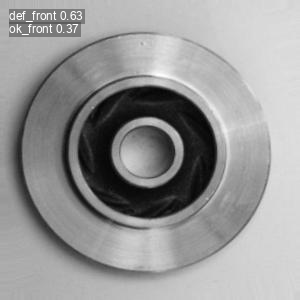

Inference time: 2846.38 ms


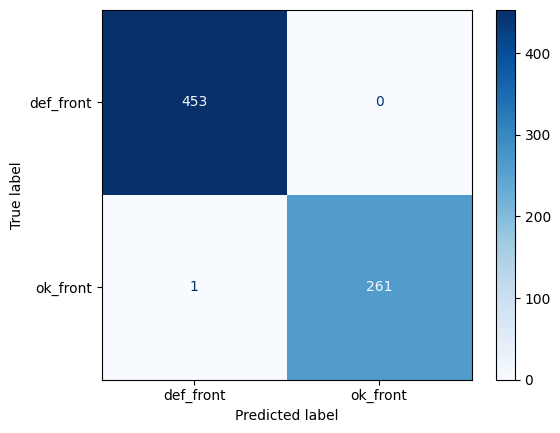

              precision    recall  f1-score   support

   def_front       1.00      1.00      1.00       453
    ok_front       1.00      1.00      1.00       262

    accuracy                           1.00       715
   macro avg       1.00      1.00      1.00       715
weighted avg       1.00      1.00      1.00       715



In [ ]:
base_dir = '/content/dataset/casting_data/casting_data'

train_data_dir, val_data_dir = split_train_val(os.path.join(base_dir, 'train'))

model = train_yolo()

test_dir = '/content/dataset/casting_data/casting_data/test'
test_and_generate_matrix(model, test_dir)

In [ ]:
!zip -r *

Streaming output truncated to the last 5000 lines.
  adding: split/train/def_front/casting_data_train_cast_def_0_2059.jpeg (deflated 2%)
  adding: split/train/def_front/casting_data_train_cast_def_0_2327.jpeg (deflated 2%)
  adding: split/train/def_front/casting_data_train_cast_def_0_7627.jpeg (deflated 2%)
  adding: split/train/def_front/casting_data_train_cast_def_0_7850.jpeg (deflated 2%)
  adding: split/train/def_front/casting_data_train_cast_def_0_5574.jpeg (deflated 2%)
  adding: split/train/def_front/casting_data_train_cast_def_0_7888.jpeg (deflated 2%)
  adding: split/train/def_front/casting_data_train_cast_def_0_7441.jpeg (deflated 2%)
  adding: split/train/def_front/casting_data_train_cast_def_0_3647.jpeg (deflated 2%)
  adding: split/train/def_front/casting_data_train_cast_def_0_8979.jpeg (deflated 2%)
  adding: split/train/def_front/casting_data_train_cast_def_0_7067.jpeg (deflated 2%)
  adding: split/train/def_front/casting_data_train_cast_def_0_3605.jpeg (deflated 2%)
  a